In [1]:
# --- imports & DB connection (reads creds from .env) ---
import os
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()  # expects PG_HOST, PG_PORT, PG_DB, PG_USER, PG_PASSWORD in .env

engine = create_engine(
    f"postgresql+psycopg2://{os.getenv('PG_USER')}:{os.getenv('PG_PASSWORD')}"
    f"@{os.getenv('PG_HOST')}:{os.getenv('PG_PORT')}/{os.getenv('PG_DB')}"
)

print("Connected ✅")

Matplotlib is building the font cache; this may take a moment.


Connected ✅


In [2]:
# --- sanity checks: counts ---
counts_sql = """
SELECT 'books' AS t, COUNT(*) FROM dwh.books
UNION ALL
SELECT 'fact_rating' AS t, COUNT(*) FROM dwh.fact_rating;
"""
pd.read_sql(counts_sql, engine)

,t,count
0,books,10000
1,fact_rating,979478


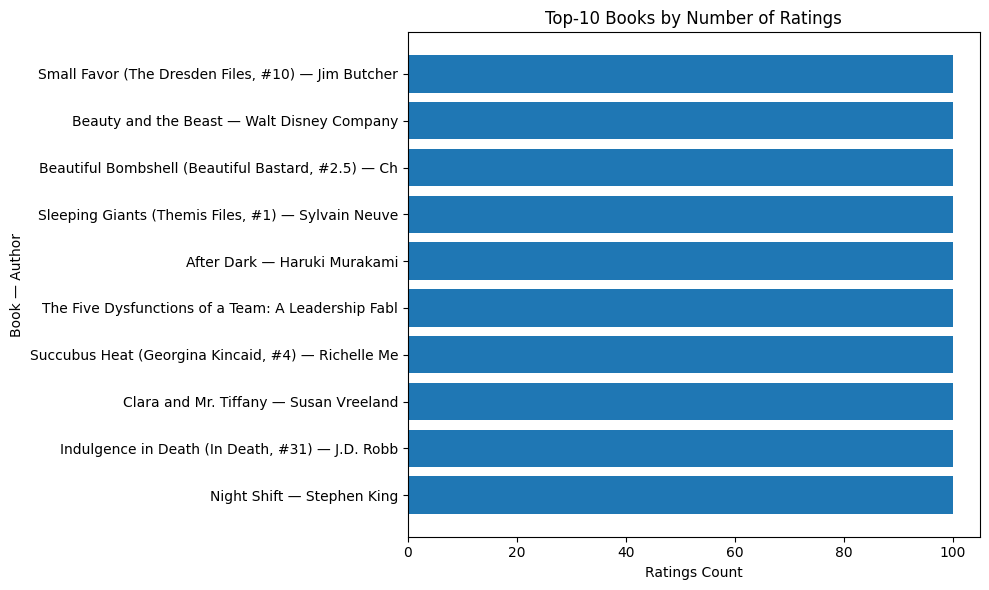

,book_id,source_book_id,title,authors,ratings_count,avg_rating
0,927979,1450,"Small Favor (The Dresden Files, #10)",Jim Butcher,100,4.32
1,1603923,5718,Beauty and the Beast,"Walt Disney Company, Ellen Titlebaum",100,4.44
2,17831617,7061,"Beautiful Bombshell (Beautiful Bastard, #2.5)",Christina Lauren,100,4.12
3,25733990,5921,"Sleeping Giants (Themis Files, #1)",Sylvain Neuvel,100,3.80
4,17803,1282,After Dark,"Haruki Murakami, Jay Rubin",100,3.56
5,21343,2327,The Five Dysfunctions of a Team: A Leadership ...,Patrick Lencioni,100,3.90
6,5148720,7780,"Succubus Heat (Georgina Kincaid, #4)",Richelle Mead,100,4.13
7,8296140,5104,Clara and Mr. Tiffany,Susan Vreeland,100,3.49
8,7685763,7328,"Indulgence in Death (In Death, #31)",J.D. Robb,100,4.15
9,10628,865,Night Shift,"Stephen King, John D. MacDonald",100,3.77


In [3]:
# --- Top-10 Books by number of ratings ---
sql_top_books = """
SELECT 
  b.book_id,
  b.source_book_id,
  b.title,
  b.authors,
  COUNT(fr.rating)        AS ratings_count,
  ROUND(AVG(fr.rating),2) AS avg_rating
FROM dwh.fact_rating fr
JOIN dwh.books b
  ON b.source_book_id = fr.book_id
GROUP BY b.book_id, b.source_book_id, b.title, b.authors
ORDER BY ratings_count DESC
LIMIT 10;
"""
df_books = pd.read_sql(sql_top_books, engine)

# Plot with matplotlib (no seaborn, one chart per cell)
plt.figure(figsize=(10, 6))
# shorten long titles for readability
labels = (df_books["title"] + " — " + df_books["authors"].str.split(",").str[0]).str.slice(0, 50)
plt.barh(labels.iloc[::-1], df_books["ratings_count"].iloc[::-1])
plt.title("Top-10 Books by Number of Ratings")
plt.xlabel("Ratings Count")
plt.ylabel("Book — Author")
plt.tight_layout()
plt.show()

df_books  # to also see the table under the chart

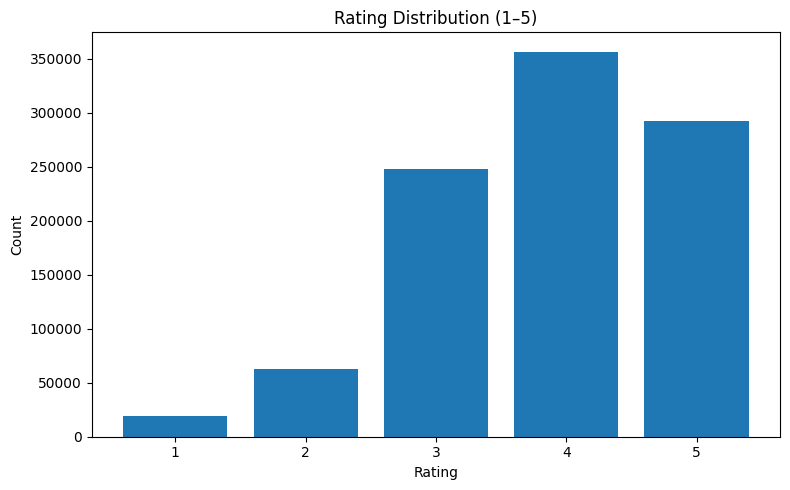

,rating,ratings_count
0,1,19513
1,2,63087
2,3,248076
3,4,356585
4,5,292217


In [4]:
# --- Rating Distribution 1..5 ---
sql_dist = """
SELECT fr.rating, COUNT(*) AS ratings_count
FROM dwh.fact_rating fr
GROUP BY fr.rating
ORDER BY fr.rating;
"""
df_dist = pd.read_sql(sql_dist, engine)

plt.figure(figsize=(8, 5))
plt.bar(df_dist["rating"].astype(str), df_dist["ratings_count"])
plt.title("Rating Distribution (1–5)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

df_dist

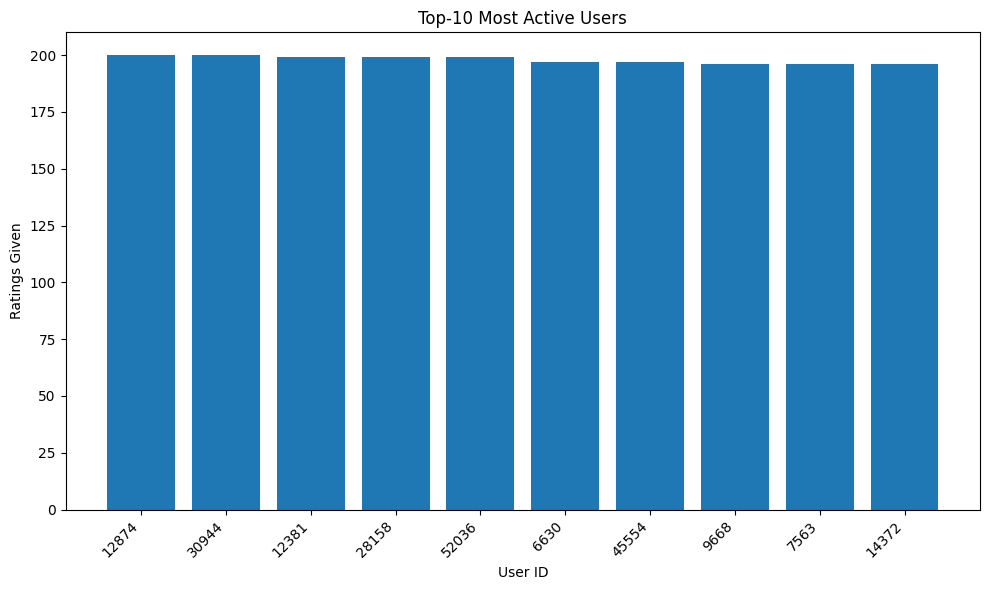

,user_id,ratings_given,avg_rating_given
0,12874,200,3.45
1,30944,200,4.21
2,12381,199,3.43
3,28158,199,3.94
4,52036,199,3.44
5,6630,197,3.57
6,45554,197,4.03
7,9668,196,3.84
8,7563,196,3.50
9,14372,196,3.60


In [5]:
# --- Top-10 Most Active Users ---
sql_top_users = """
SELECT 
  fr.user_id,
  COUNT(*) AS ratings_given,
  ROUND(AVG(fr.rating),2) AS avg_rating_given
FROM dwh.fact_rating fr
GROUP BY fr.user_id
ORDER BY ratings_given DESC
LIMIT 10;
"""
df_users = pd.read_sql(sql_top_users, engine)

plt.figure(figsize=(10, 6))
plt.bar(df_users["user_id"].astype(str), df_users["ratings_given"])
plt.title("Top-10 Most Active Users")
plt.xlabel("User ID")
plt.ylabel("Ratings Given")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

df_users

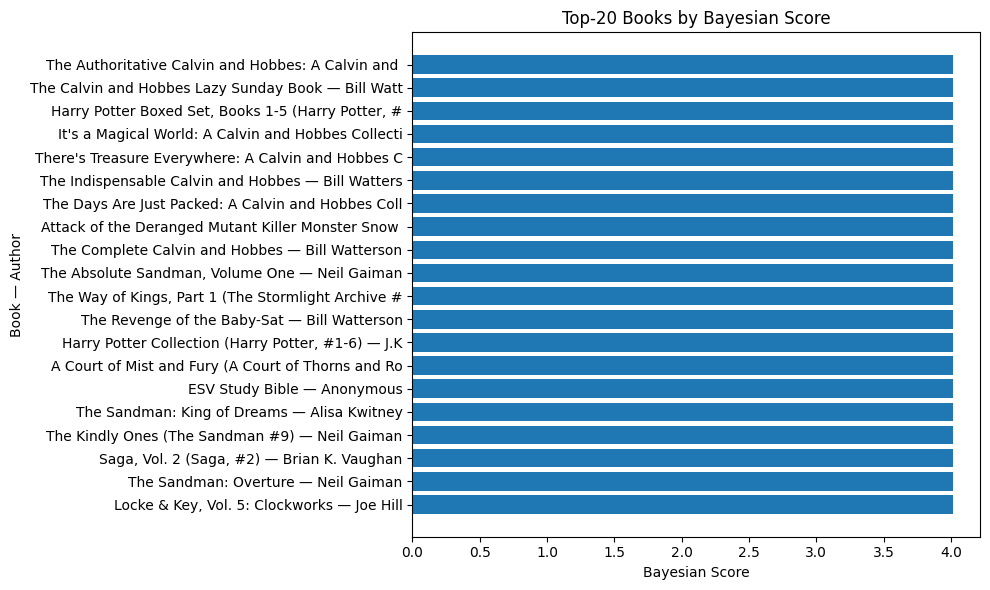

,book_id,source_book_id,title,authors,n,r,bayesian_score
0,59715,6590,The Authoritative Calvin and Hobbes: A Calvin ...,Bill Watterson,100,4.75,4.015
1,24494,5580,The Calvin and Hobbes Lazy Sunday Book,Bill Watterson,100,4.75,4.015
2,8,3275,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...","J.K. Rowling, Mary GrandPré",100,4.77,4.015
3,24814,4483,It's a Magical World: A Calvin and Hobbes Coll...,Bill Watterson,100,4.75,4.015
4,70489,6361,There's Treasure Everywhere: A Calvin and Hobb...,Bill Watterson,100,4.77,4.015
5,24815,6920,The Indispensable Calvin and Hobbes,Bill Watterson,99,4.78,4.015
6,24818,5207,The Days Are Just Packed: A Calvin and Hobbes ...,Bill Watterson,99,4.78,4.015
7,70487,9566,Attack of the Deranged Mutant Killer Monster S...,Bill Watterson,99,4.78,4.015
8,24812,3628,The Complete Calvin and Hobbes,Bill Watterson,100,4.73,4.014
9,23753,8109,"The Absolute Sandman, Volume One","Neil Gaiman, Mike Dringenberg, Chris Bachalo, ...",100,4.71,4.014


In [6]:
# --- Top-20 by Bayesian Score (uses facts, not the avg in books.csv) ---
sql_bayes = """
WITH params AS (SELECT 4.0::numeric AS m, 5000::int AS C),
agg AS (
  SELECT 
    b.book_id,
    b.source_book_id,
    b.title,
    b.authors,
    COUNT(*)::bigint AS n,            -- number of ratings
    AVG(fr.rating)::numeric(4,2) AS r -- average rating from facts
  FROM dwh.fact_rating fr
  JOIN dwh.books b ON b.source_book_id = fr.book_id
  GROUP BY b.book_id, b.source_book_id, b.title, b.authors
)
SELECT 
  a.*,
  ROUND(((p.C * p.m) + (a.n * a.r)) / NULLIF((p.C + a.n),0), 3) AS bayesian_score
FROM agg a CROSS JOIN params p
ORDER BY bayesian_score DESC, n DESC
LIMIT 20;
"""
df_bayes = pd.read_sql(sql_bayes, engine)

plt.figure(figsize=(10, 6))
labels = (df_bayes["title"] + " — " + df_bayes["authors"].str.split(",").str[0]).str.slice(0, 50)
plt.barh(labels.iloc[::-1], df_bayes["bayesian_score"].iloc[::-1])
plt.title("Top-20 Books by Bayesian Score")
plt.xlabel("Bayesian Score")
plt.ylabel("Book — Author")
plt.tight_layout()
plt.show()

df_bayes

In [7]:
# Save last figure (repeat per chart as needed)
out_dir = "notebooks/exports"
os.makedirs(out_dir, exist_ok=True)
plt.gcf().savefig(os.path.join(out_dir, "top10_books.png"), dpi=200)

<Figure size 640x480 with 0 Axes>